In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_character = pd.read_csv('assets/simpsons_characters.csv')
df_lines = pd.read_csv('assets/simpsons_script_lines.csv', low_memory=False)
df_episode = pd.read_csv('assets/simpsons_episodes.csv')
df_location = pd.read_csv('assets/simpsons_locations.csv')

# Task: Predict whether a Simpson episode is 'popular' with Machine Learning

**Popularity is defined by "IMDB rating" from simpsons_episodes.csv file.**     
4 csv files are provided and loaded as source data. The original data are downloaded from https://data.world/data-society/the-simpsons-by-the-data.

# Goal
Construct feature columns for each episode that you think are related to popularity with the given datasets and construct the target column 'popularity', which is a binary class.    

**Example feature columns**   
 - How many characters are in that episode?    
 - How many lines are spoken by each character in that episode?     
 - etc.   

We will guide you through the preprocessing, or you can jump to down load the processed sample data and work on machine learning models.      

The sample data will not give you the best result, and it is suggested that you go through the preprocessing and learn how different techniques affect model results. Also, you are more than welcome to create your own features and explore all possibilities!

# Pre-processing

## Calculate number of lines spoken by each character in each Episode

Note: Here we also count interjections even there's no words. (i.e. speaking_line=false, spoken_words=Nan etc.)

In [2]:
# It is important to check data type for each column and do neccessary conversion.
# (e.g. speaking_line is object not boolean)
# (e.g. Non-Null Count can show which columns have null values)
df_lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158271 entries, 0 to 158270
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  158271 non-null  int64  
 1   episode_id          158271 non-null  int64  
 2   number              158271 non-null  int64  
 3   raw_text            158271 non-null  object 
 4   timestamp_in_ms     158271 non-null  object 
 5   speaking_line       158271 non-null  object 
 6   character_id        140750 non-null  object 
 7   location_id         157864 non-null  float64
 8   raw_character_text  140749 non-null  object 
 9   raw_location_text   157863 non-null  object 
 10  spoken_words        132112 non-null  object 
 11  normalized_text     132087 non-null  object 
 12  word_count          132112 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 15.7+ MB


> When speaking_line is false, there might be character or no character. We need to decide how to process it. 
> 
> *Thought: do you think location appeared in episodes can be relevant to popularity as well? (Maybe we can use df_location?)*

In [3]:
df_lines[df_lines.speaking_line=='false']

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
8,9557,32,217,(Apartment Building: Ext. apartment building -...,889000,false,NaN,374.0,NaN,Apartment Building,NaN,NaN,NaN
16,9565,32,225,(Springfield Elementary School: EXT. ELEMENTAR...,918000,false,NaN,3.0,NaN,Springfield Elementary School,NaN,NaN,NaN
27,9576,32,236,Bart Simpson: (ANGUISHED SCREAM),936000,false,8,3.0,Bart Simpson,Springfield Elementary School,NaN,NaN,NaN
29,75766,263,106,(Moe's Tavern: Int. Moe's - evening),497000,false,NaN,15.0,NaN,Moe's Tavern,NaN,NaN,NaN
35,9583,32,243,(Train Station: int. train station - afternoon),960000,false,NaN,375.0,NaN,Train Station,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158194,9472,32,132,(Springfield Elementary School: INT. ELEMENTAR...,601000,false,NaN,3.0,NaN,Springfield Elementary School,NaN,NaN,NaN
158205,9483,32,143,(Simpson Home: INT. SIMPSON HOUSE - LIVINGING ...,646000,false,NaN,5.0,NaN,Simpson Home,NaN,NaN,NaN
158215,9493,32,153,(Museum: INT. MUSEUM - ADMISSION AREA - DAY),686000,false,NaN,372.0,NaN,Museum,NaN,NaN,NaN
158243,9521,32,181,(SIMPSON HOUSE - BASEMENT STAIRCASE: INT. SIMP...,789000,false,NaN,373.0,NaN,SIMPSON HOUSE - BASEMENT STAIRCASE,NaN,NaN,NaN


> When character_id is NaN, it seems to be background/location description from raw_text column.     
> Since we want to focuse on lines spoken by characters now, let's **drop the rows where character_id is NaN.**

In [4]:
df_lines[df_lines.speaking_line=='false'].iloc[1]['raw_text']

'(Springfield Elementary School: EXT. ELEMENTARY - SCHOOL PLAYGROUND - AFTERNOON)'

In [5]:
df_lines = df_lines.dropna(subset=['character_id'])
df_lines.shape

(140750, 13)

In [6]:
df_lines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140750 entries, 0 to 158270
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  140750 non-null  int64  
 1   episode_id          140750 non-null  int64  
 2   number              140750 non-null  int64  
 3   raw_text            140750 non-null  object 
 4   timestamp_in_ms     140750 non-null  object 
 5   speaking_line       140750 non-null  object 
 6   character_id        140750 non-null  object 
 7   location_id         140343 non-null  float64
 8   raw_character_text  140749 non-null  object 
 9   raw_location_text   140342 non-null  object 
 10  spoken_words        132110 non-null  object 
 11  normalized_text     132085 non-null  object 
 12  word_count          132110 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 15.0+ MB


> Each row is one line for each character, so we can **groupby character_id and episode_id** to count how many rows(lines) they have spoken for each episode

In [7]:
# fill NaN spoken words column with empty string 
df_lines['spoken_words'] = df_lines['spoken_words'].fillna('')
# count character lines overall (you can either groupby character_id or raw_character_text):
character_lines_count_by_episode = df_lines.groupby(['character_id', 'episode_id']).count()[['spoken_words']].reset_index()
character_lines_count_by_episode.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21288 entries, 0 to 21287
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   character_id  21288 non-null  object
 1   episode_id    21288 non-null  int64 
 2   spoken_words  21288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 499.1+ KB


In [8]:
character_lines_count_by_episode.head()

,character_id,episode_id,spoken_words
0,1,1,43
1,1,2,23
2,1,3,15
3,1,4,41
4,1,5,17


> Then we want to merge this dataset with df_character, character_id is always more reliable than raw_character_text. For raw text there might be variation in spelling and causing problem when merge.

In [9]:
df_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6722 entries, 0 to 6721
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               6722 non-null   int64 
 1   name             6722 non-null   object
 2   normalized_name  6722 non-null   object
 3   gender           323 non-null    object
dtypes: int64(1), object(3)
memory usage: 210.2+ KB


> df_character has id as int data type, and in our character_lines_count_by_episode dataframe, character_id is of data type object, so need to convert them to consistent type before merge.

In [10]:
def convert_to_int(x):
    try:
        return int(x)
    except:
        return -999

character_lines_count_by_episode['character_id'] = character_lines_count_by_episode['character_id'].apply(convert_to_int)
# merge 2 datasets and clean up column names
character_lines_count_by_episode = character_lines_count_by_episode.merge(df_character, left_on='character_id', right_on='id', how='left')
character_lines_count_by_episode = character_lines_count_by_episode.drop('id', axis=1).sort_values('character_id')
character_lines_count_by_episode = character_lines_count_by_episode.rename(columns={'spoken_words':'lines_count'})

In [11]:
# sort characters by number of lines they have spoken
character_lines_count_by_episode = character_lines_count_by_episode.sort_values('lines_count', ascending=False)

In [12]:
# Not surprising that Homer Simpsons have the most lines in most cases
character_lines_count_by_episode.head()

,character_id,episode_id,lines_count,name,normalized_name,gender
6752,2,231,145,Homer Simpson,homer simpson,m
6545,2,24,129,Homer Simpson,homer simpson,m
19145,8,34,122,Bart Simpson,bart simpson,m
6872,2,351,122,Homer Simpson,homer simpson,m
6814,2,293,119,Homer Simpson,homer simpson,m


> There are some characters with gender as NaN, looking into it, they are mostly background noise. But we will keep them for now.

In [13]:
character_lines_count_by_episode[character_lines_count_by_episode.gender.isnull()]

,character_id,episode_id,lines_count,name,normalized_name,gender
16531,5669,465,49,Kurt Hardwick,kurt hardwick,NaN
17041,5996,498,40,Bar Rag,bar rag,NaN
13842,4174,333,30,TEN-YEAR-OLD MARGE,ten-year-old marge,NaN
18024,6666,559,29,MR. LASSEN,mr lassen,NaN
8136,2251,413,28,Donny,donny,NaN
...,...,...,...,...,...,...
17904,658,214,1,Everyone,everyone,NaN
17906,658,283,1,Everyone,everyone,NaN
17907,658,294,1,Everyone,everyone,NaN
17909,658,470,1,Everyone,everyone,NaN


> Use **pivot** function to rearrange information

In [14]:
character_lines_count_by_episode = character_lines_count_by_episode.pivot(index=['name'], columns = ['episode_id'])[['lines_count']]
character_lines_count_by_episode = character_lines_count_by_episode['lines_count'].fillna(0.0)

In [15]:
character_lines_count_by_episode

episode_id,1,2,3,4,5,6,7,8,9,10,...,559,560,561,562,563,564,565,566,567,568
name,,,,,,,,,,,,,,,,,,,,,
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""For Dummies"" Author",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Just Stamp the Ticket"" Man",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Mario"" #2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Shorts"" Bart",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
alligator,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iPod,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
newsstand Operator,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> From the **name** index, we can see there are a lot of 'noise' information, e.g. **"For Dummies" Author** probably does not carry much information towards an episode's popularity. 
>
> Therefore, we need to **select features with more consideration**.
>
> **Solution example: Filter/Select characters by number of lines they have across all episodes**

In [16]:
top_n = 300
top_characters = list(character_lines_count_by_episode.sum(axis=1).sort_values(ascending=False)[:top_n].index)
top_characters

['Homer Simpson',
 'Marge Simpson',
 'Bart Simpson',
 'Lisa Simpson',
 'C. Montgomery Burns',
 'Moe Szyslak',
 'Seymour Skinner',
 'Ned Flanders',
 'Grampa Simpson',
 'Milhouse Van Houten',
 'Chief Wiggum',
 'Krusty the Clown',
 'Nelson Muntz',
 'Lenny Leonard',
 'Apu Nahasapeemapetilon',
 'Waylon Smithers',
 'Kent Brockman',
 'Carl Carlson',
 'Edna Krabappel-Flanders',
 'Dr. Julius Hibbert',
 'Barney Gumble',
 'Selma Bouvier',
 'Sideshow Bob',
 'Rev. Timothy Lovejoy',
 'Groundskeeper Willie',
 'Crowd',
 'Gary Chalmers',
 'Ralph Wiggum',
 'Mayor Joe Quimby',
 'Comic Book Guy',
 'Patty Bouvier',
 'Otto Mann',
 'Martin Prince',
 'Announcer',
 'Kids',
 'Jimbo Jones',
 'Sideshow Mel',
 'Lou',
 'Professor Jonathan Frink',
 'Fat Tony',
 'Kearney Zzyzwicz',
 'Agnes Skinner',
 'Snake Jailbird',
 'Kirk Van Houten',
 'Cletus Spuckler',
 'Troy McClure',
 'DOLPH',
 'Todd Flanders',
 'Audience',
 'Lionel Hutz',
 'Miss Hoover',
 'Gil Gunderson',
 'Rainier Wolfcastle',
 'Narrator',
 'The Rich Texan',

In [17]:
character_lines_count_by_episode_filtered = character_lines_count_by_episode[character_lines_count_by_episode.index.isin(top_characters)]

In [18]:
character_lines_count_by_episode_filtered

episode_id,1,2,3,4,5,6,7,8,9,10,...,559,560,561,562,563,564,565,566,567,568
name,,,,,,,,,,,,,,,,,,,,,
10-Year-Old Homer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARTIE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agnes Skinner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
Akira,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alec Baldwin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wayne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Woman,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Women,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> Note there are only 564 columns, but there are in total 600 episodes based on df_episode, why some episode information is missing?  
>
> So it mean there are **some episodes does not have script record**, however, they still have some basic information from df_episode, we will keep them even they lack character features.

In [19]:
df_episode.shape

(600, 14)

In [20]:
len(df_lines.episode_id.unique())

564

# Episode Dataset

Now let's take a look at the episode dataset, where we have more information for each episode.

> **From here we split the episode into 2 groups: popular/unpopular based on the 'imdb_rating' column**     

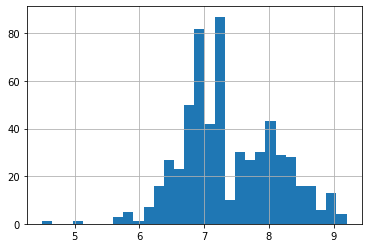

In [21]:
# Take a look at the rating distribution first
df_episode.imdb_rating.hist(bins=30);

In [22]:
# define the imdb threshold for popular and 'unpopular'
threshold = 7.3

# Create the popularity_class based on threshold
df_episode['popularity_class'] = df_episode.imdb_rating>=threshold
df_episode['popularity_class'] = df_episode['popularity_class'].astype(int)

In [23]:
# 1 meaning rating over threshold (popular)
# 0 meaning rating below threshold (unpopular)
df_episode['popularity_class'].value_counts()

1    300
0    300
Name: popularity_class, dtype: int64

> We tried to keep the problem a **balanced binary classification**!       
>
> You can try to adjust the threshold, but keep in mind when the 2 classes are unbalanced, be careful on choosing a proper evaluation criteria! (e.g. Accuracy is probably not ideal)

In [24]:
# Now check what other information we have from this dataframe
df_episode.columns

Index(['id', 'image_url', 'imdb_rating', 'imdb_votes', 'number_in_season',
       'number_in_series', 'original_air_date', 'original_air_year',
       'production_code', 'season', 'title', 'us_viewers_in_millions',
       'video_url', 'views', 'popularity_class'],
      dtype='object')

In [25]:
df_episode[['imdb_rating', 'imdb_votes','number_in_season']].corr()

,imdb_rating,imdb_votes,number_in_season
imdb_rating,1.000000,0.783829,-0.000065
imdb_votes,0.783829,1.000000,-0.103570
number_in_season,-0.000065,-0.103570,1.000000


> As **imdb_rating** and **imdb_votes** are closely related (0.78), and our popularity class is defined by imdb_rating, we should remove them from feature columns.
> 
> **'original_air_date'** and **'title'** are not numerical information, drop them for now.      
> *Hint: if you are familiar with NLP technics, feel free to extract feature from title or even character lines.*

In [26]:
related_cols=['number_in_season', 
              'number_in_series', 
              'original_air_year',
              'season', 
              'us_viewers_in_millions',
              'views', 
              'popularity_class']

In [27]:
df_episode = df_episode[related_cols]
df_episode = df_episode.reset_index().rename(columns={'index':'episode_id'})

In [28]:
df_episode.head()

,episode_id,number_in_season,number_in_series,original_air_year,season,us_viewers_in_millions,views,popularity_class
0,0,10,10,1990,1,30.3,50816.0,1
1,1,12,12,1990,1,30.4,62561.0,1
2,2,1,14,1990,2,33.6,59575.0,1
3,3,4,17,1990,2,26.1,64959.0,1
4,4,6,19,1990,2,25.4,50691.0,1


In [29]:
# combine the information we have
character_lines_with_episode_info = pd.merge(character_lines_count_by_episode_filtered.T, 
                                             df_episode, on='episode_id', how='outer')

In [30]:
character_lines_with_episode_info.shape

(600, 308)

In [31]:
# Sort the columns by top_characters plus the related columns, remember the index is episode_id (total 600 episodes)
character_lines_with_episode_info[top_characters+related_cols]

,Homer Simpson,Marge Simpson,Bart Simpson,Lisa Simpson,C. Montgomery Burns,Moe Szyslak,Seymour Skinner,Ned Flanders,Grampa Simpson,Milhouse Van Houten,...,Gary,Maya,CAIN,number_in_season,number_in_series,original_air_year,season,us_viewers_in_millions,views,popularity_class
0,117.0,43.0,51.0,21.0,3.0,2.0,3.0,7.0,2.0,2.0,...,0.0,0.0,0.0,12,12,1990,1,30.40,62561.0,1
1,57.0,23.0,82.0,10.0,0.0,0.0,18.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1,14,1990,2,33.60,59575.0,1
2,59.0,15.0,33.0,11.0,13.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4,17,1990,2,26.10,64959.0,1
3,83.0,41.0,43.0,35.0,18.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6,19,1990,2,25.40,50691.0,1
4,33.0,17.0,102.0,28.0,0.0,0.0,6.0,0.0,20.0,5.0,...,0.0,0.0,0.0,8,21,1990,2,26.20,57605.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14,500,2012,23,5.77,45226.0,0
596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16,502,2012,23,4.97,44818.0,1
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,511,2012,24,5.65,39687.0,0
598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12,542,2014,25,2.69,39292.0,0


> Note that we have NaN values in the dataset, how would you deal with them? **Imputation Methods**

In [32]:
y_all = character_lines_with_episode_info['popularity_class']
X_all = character_lines_with_episode_info.drop('popularity_class',1)
X_all.shape, y_all.shape, character_lines_with_episode_info.shape

/tmp/ipykernel_172/269455014.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_all = character_lines_with_episode_info.drop('popularity_class',1)


((600, 307), (600,), (600, 308))

In [33]:
y_all.to_csv('assets/y_all.csv', index=True)
X_all.to_csv('assets/X_all.csv', index=True)